In [105]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np, os, json
import qiskit.quantum_info as qi
import pandas as pd
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, measure
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src = '../docs/compilation-design1.png' height ='500px'>
<img src = '../docs/compilation-design2.png' height ='500px'>

### Drawing

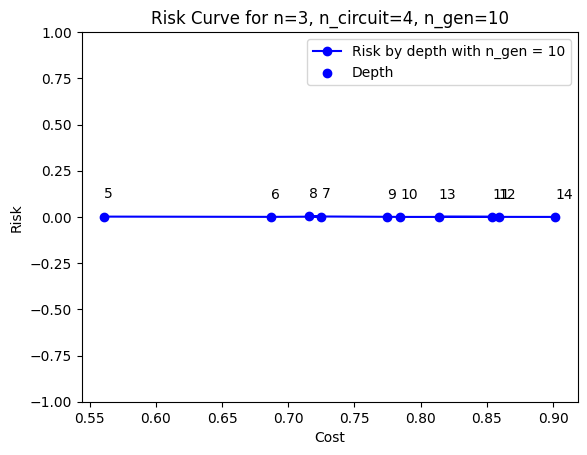

In [33]:
df = pd.read_csv('risk.csv')
# draw risk curve and cost curve for each depth with same n, n_circuit and n_gen
n = 3
n_circuit = 4  # replace with your actual value
n_gen = 10  # replace with your actual value
for n_gen in [10]:
    # Filter the data
    df_filtered = df[(df['n'] == n) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
    # Sort the data by 'd' (depth)
    df_filtered = df_filtered.sort_values('d')
    # labeling each point by depth value
    for i, d in enumerate(df_filtered['d']):
        plt.annotate(d, (df_filtered['cost'].iloc[i], df_filtered['risk'].iloc[i] + 0.1))
    plt.plot(df_filtered['cost'], df_filtered['risk'], label=f'Risk by depth with n_gen = {n_gen}', marker = 'o', color = 'b')
# legend for annotate points
plt.scatter([], [], label='Depth', c='blue')
plt.xlabel('Cost')
plt.ylabel('Risk')
plt.ylim(-1, 1)
plt.title(f'Risk Curve for n={n}, n_circuit={n_circuit}, n_gen={n_gen}')
plt.legend()
plt.show()

In [181]:
def indices_for_sorted_order(data_list):
    # Enumerate the list and then sort by the elements, keeping track of the original indices
    sorted_indices = [index for index, value in sorted(enumerate(data_list), key=lambda x: x[1])]
    return sorted_indices

def sort_by_indices(data_list, index_list):
    # Ensure the index list is the same length as the data list
    if len(data_list) != len(index_list):
        raise ValueError("Length of index_list must be the same as length of data_list")

    # Sort the data_list according to the index_list
    sorted_list = [data_list[i] for i in index_list]
    return sorted_list

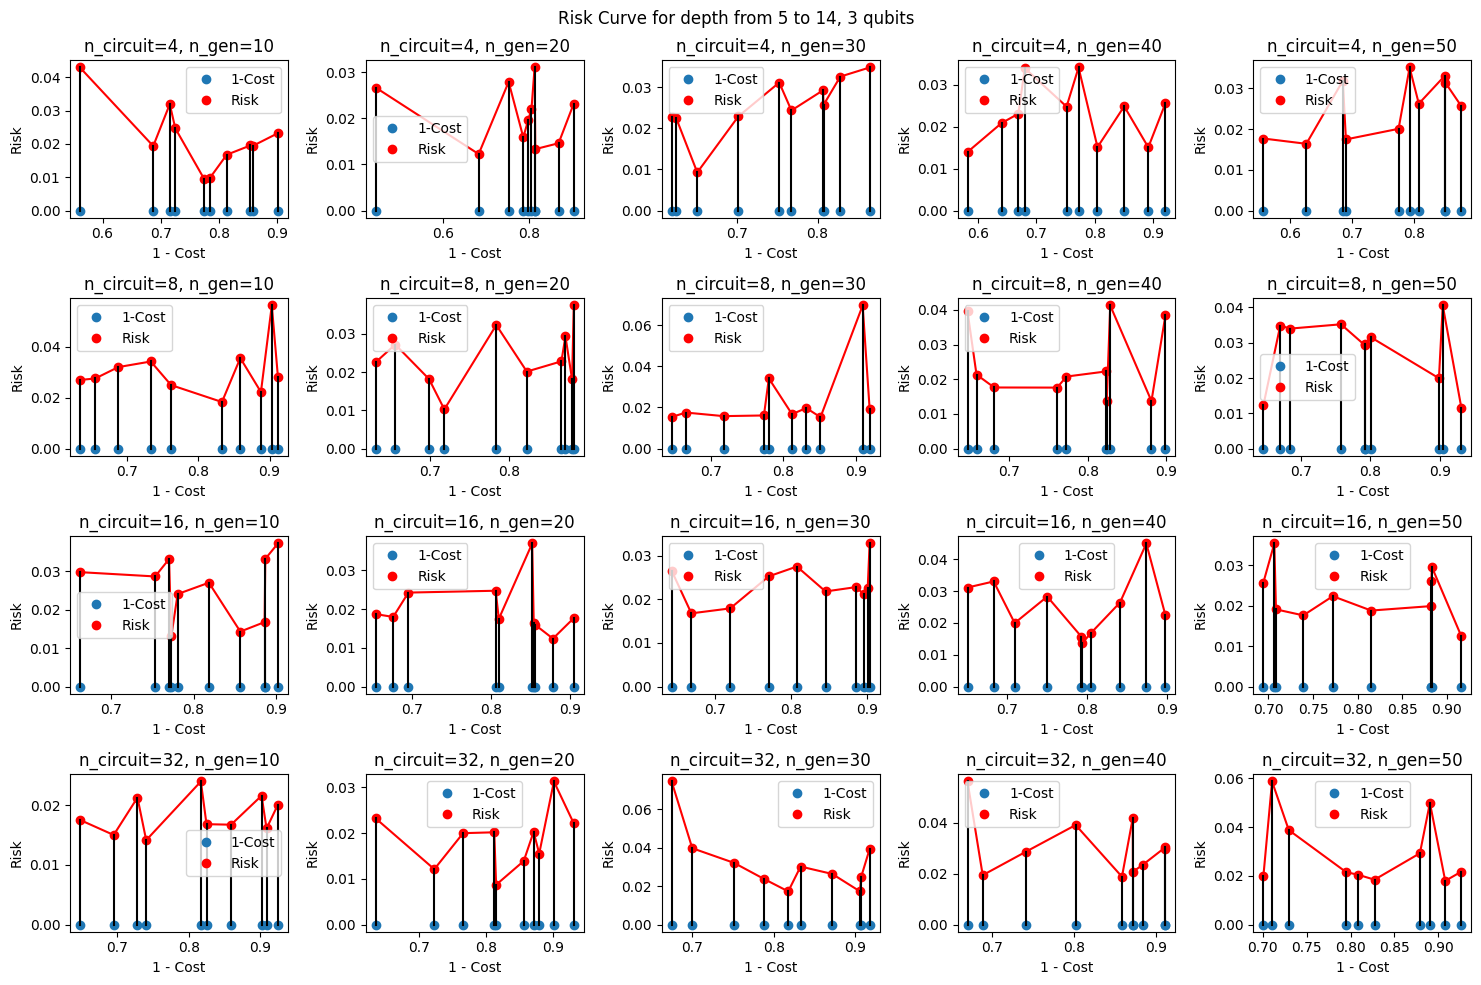

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

n = 3
# Load the data
df = pd.read_csv('cost.csv')  # replace with your actual file path

# Filter the data for n = 3
df_filtered = df[df['n'] == n]

# Group by n_circuit, n_gen, and d, and calculate the mean of risk and cost
grouped = df_filtered.groupby(['n_circuit', 'n_gen', 'd'])['cost'].mean().reset_index()

# Get the unique values of n_circuit and n_gen
n_circuit_values = grouped['n_circuit'].unique()
n_gen_values = grouped['n_gen'].unique()

# Plot the average risk and cost curves for each n_circuit and n_gen
fig, axs = plt.subplots(len(n_circuit_values), len(n_gen_values), figsize=(15, 10))

for i, n_circuit in enumerate(n_circuit_values):
    for j, n_gen in enumerate(n_gen_values):
        # Plot cost
        data = grouped[(grouped['n_circuit'] == n_circuit) & (grouped['n_gen'] == n_gen)]
        axs[i, j].plot(data['cost'], [0]*(len(data['cost'])), label='1-Cost', linestyle = '', marker = 'o')
        axs[i, j].set_title(f'n_circuit={n_circuit}, n_gen={n_gen}')
        risks = []
        # Plot risk
        for d in range(5,15):
            # read value by key json
            with open(f'risk_{n}.json') as f:
                risk_data = json.load(f)
            risk = risk_data[f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}']
            risks.append(risk)
        x = list((data['cost'] ))
        y = list(np.mean(risks, 1))
        y = sort_by_indices(y, indices_for_sorted_order(x))
        x = sorted(x)
        for k in range(0, len(x) - 1):
            axs[i,j].plot([x[k],x[k + 1]], [y[k], y[k+1]], color='r')
        axs[i,j].plot(x, y, label='Risk', linestyle='', marker = 'o', color = 'r')
        
        #axs[i, j].fill_between(data['cost'], np.asarray(y) + np.asarray(yvar), np.asarray(y) - np.asarray(yvar), alpha = 0.2, color='r')
        axs[i, j].legend()
        axs[i, j].set_xlabel('1 - Cost')
        axs[i,j].set_ylabel('Risk')
        for k in range(0, len(x)):
            axs[i,j].plot([x[k],x[k]], [0,y[k]], color='black')

fig.suptitle(f'Risk Curve for depth from 5 to 14, 3 qubits')
plt.tight_layout()
plt.show()

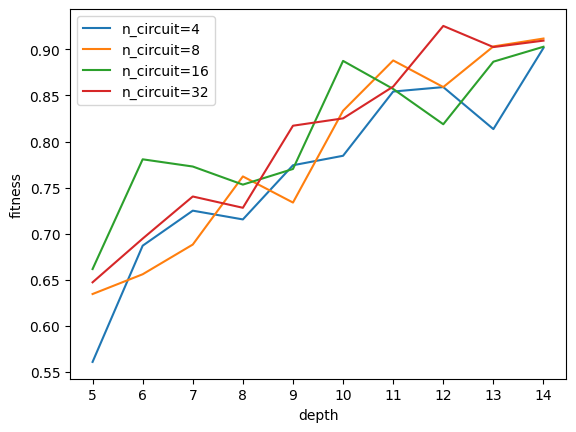

In [21]:
num_qubits = 3
num_circuit = 4
num_generation = 10
depths = range(5, 15)
# qubit = 2, depth = 4
# qubit = 3, depth around 15
# qubit = 4, depth around 40
# qubit = 5, depth around 100
# num_generation = 10, 20, 30, ...
# num_circuit = 4, 8, 16, 32, ...
# depth = 2,3,4, ...

# read all files metadata.json inside list of folders

for num_circuit in [4, 8, 16, 32]:
    best_fitness = []
    for depth in depths:
        envx = EEnvironment.load(f'n={num_qubits},d={depth},n_circuit={num_circuit},n_gen={num_generation}', None)
        best_fitness.append(np.max(envx.metadata.best_fitnesss))
    plt.plot(best_fitness, label=f'n_circuit={num_circuit}')
    
plt.ylabel('fitness')
plt.xlabel('depth')
plt.xticks(range(len(depths)), depths)
plt.legend()

### Update cost column from folders

In [203]:
import pandas as pd

# Define the column names
columns = ['n', 'depth', 'n_circuit', 'n_gen', 'cost']

# Create an empty DataFrame with the column names
df = pd.DataFrame(columns=columns)
ns = [2, 3, 4, 5, 6]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]


# Append the lists of values as new rows to the DataFrame
for n in ns:
    for num_circuit in num_circuits:
        for num_generation in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(5, 30))
            elif n == 5:
                depths = list(range(5, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for depth in depths:
                df.loc[len(df)] = [n, depth, num_circuit, num_generation, 0]
df.to_csv('cost.csv', index=False)

In [206]:
# create an empty csv file has columns: n,depth,n_circuit,n_gen,risk
# n = 2,3,4,5,6
# depth = 2,3,4, ...
# n_circuit = 4,8,16,32, ...
# n_gen = 10,20,30, ...
# risk = 0.1,0.2,0.3, ...

def changeCost(n, d, n_circuit, n_gen, cost):
    df = pd.read_csv('cost.csv')
    filtered_df = df[(df['n'] == n) & (df['d'] == d) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
    row_index = filtered_df.index.tolist()[0]
    if df.loc[row_index]['cost'] == 0:
        df.loc[row_index] = [n, d, n_circuit, n_gen, cost]
        df.to_csv('cost.csv', index=False)
    return

import pandas as pd
import csv

ns = [2, 3, 4, 5, 6]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(5, 30))
            elif n == 5:
                depths = list(range(5, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')
                    envx = EEnvironment.load(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
                    best_fitness = (np.max(envx.metadata.best_fitnesss))
                    changeCost(n, d, n_circuit, n_gen, best_fitness)


n=2,d=2,n_circuit=4,n_gen=10
n=2,d=3,n_circuit=4,n_gen=10
n=2,d=2,n_circuit=4,n_gen=20
n=2,d=3,n_circuit=4,n_gen=20
n=2,d=2,n_circuit=4,n_gen=30
n=2,d=3,n_circuit=4,n_gen=30
n=2,d=2,n_circuit=4,n_gen=40
n=2,d=3,n_circuit=4,n_gen=40
n=2,d=2,n_circuit=4,n_gen=50
n=2,d=3,n_circuit=4,n_gen=50
n=2,d=2,n_circuit=8,n_gen=10
n=2,d=3,n_circuit=8,n_gen=10
n=2,d=2,n_circuit=8,n_gen=20
n=2,d=3,n_circuit=8,n_gen=20
n=2,d=2,n_circuit=8,n_gen=30
n=2,d=3,n_circuit=8,n_gen=30
n=2,d=2,n_circuit=8,n_gen=40
n=2,d=3,n_circuit=8,n_gen=40
n=2,d=2,n_circuit=8,n_gen=50
n=2,d=3,n_circuit=8,n_gen=50
n=2,d=2,n_circuit=16,n_gen=10
n=2,d=3,n_circuit=16,n_gen=10
n=2,d=2,n_circuit=16,n_gen=20
n=2,d=3,n_circuit=16,n_gen=20
n=2,d=2,n_circuit=16,n_gen=30
n=2,d=3,n_circuit=16,n_gen=30
n=2,d=2,n_circuit=16,n_gen=40
n=2,d=3,n_circuit=16,n_gen=40
n=2,d=2,n_circuit=16,n_gen=50
n=2,d=3,n_circuit=16,n_gen=50
n=2,d=2,n_circuit=32,n_gen=10
n=2,d=3,n_circuit=32,n_gen=10
n=2,d=2,n_circuit=32,n_gen=20
n=2,d=3,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=21,n_circuit=4,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=4,n_gen=10
n=4,d=23,n_circuit=4,n_gen=10
n=4,d=24,n_circuit=4,n_gen=10
n=4,d=25,n_circuit=4,n_gen=10
n=4,d=26,n_circuit=4,n_gen=10
n=4,d=27,n_circuit=4,n_gen=10
n=4,d=28,n_circuit=4,n_gen=10
n=4,d=29,n_circuit=4,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=5,n_circuit=4,n_gen=20
n=4,d=6,n_circuit=4,n_gen=20
n=4,d=7,n_circuit=4,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=4,n_gen=20
n=4,d=9,n_circuit=4,n_gen=20
n=4,d=10,n_circuit=4,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=11,n_circuit=4,n_gen=20
n=4,d=12,n_circuit=4,n_gen=20
n=4,d=13,n_circuit=4,n_gen=20
n=4,d=14,n_circuit=4,n_gen=20
n=4,d=15,n_circuit=4,n_gen=20
n=4,d=16,n_circuit=4,n_gen=20
n=4,d=17,n_circuit=4,n_gen=20
n=4,d=18,n_circuit=4,n_gen=20
n=4,d=19,n_circuit=4,n_gen=20
n=4,d=20,n_circuit=4,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=21,n_circuit=4,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=4,n_gen=20
n=4,d=23,n_circuit=4,n_gen=20
n=4,d=24,n_circuit=4,n_gen=20
n=4,d=25,n_circuit=4,n_gen=20
n=4,d=26,n_circuit=4,n_gen=20
n=4,d=27,n_circuit=4,n_gen=20
n=4,d=28,n_circuit=4,n_gen=20
n=4,d=29,n_circuit=4,n_gen=20
n=4,d=5,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=6,n_circuit=4,n_gen=30
n=4,d=7,n_circuit=4,n_gen=30
n=4,d=8,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=4,n_gen=30
n=4,d=10,n_circuit=4,n_gen=30
n=4,d=11,n_circuit=4,n_gen=30
n=4,d=12,n_circuit=4,n_gen=30
n=4,d=13,n_circuit=4,n_gen=30
n=4,d=14,n_circuit=4,n_gen=30
n=4,d=15,n_circuit=4,n_gen=30
n=4,d=16,n_circuit=4,n_gen=30
n=4,d=17,n_circuit=4,n_gen=30
n=4,d=18,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=19,n_circuit=4,n_gen=30
n=4,d=20,n_circuit=4,n_gen=30
n=4,d=21,n_circuit=4,n_gen=30
n=4,d=22,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=23,n_circuit=4,n_gen=30
n=4,d=24,n_circuit=4,n_gen=30
n=4,d=25,n_circuit=4,n_gen=30
n=4,d=26,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=27,n_circuit=4,n_gen=30
n=4,d=28,n_circuit=4,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=4,n_gen=30
n=4,d=5,n_circuit=4,n_gen=40
n=4,d=6,n_circuit=4,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=4,n_gen=40
n=4,d=8,n_circuit=4,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=4,n_gen=40
n=4,d=10,n_circuit=4,n_gen=40
n=4,d=11,n_circuit=4,n_gen=40
n=4,d=12,n_circuit=4,n_gen=40
n=4,d=13,n_circuit=4,n_gen=40
n=4,d=14,n_circuit=4,n_gen=40
n=4,d=15,n_circuit=4,n_gen=40
n=4,d=16,n_circuit=4,n_gen=40
n=4,d=17,n_circuit=4,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=18,n_circuit=4,n_gen=40
n=4,d=19,n_circuit=4,n_gen=40
n=4,d=20,n_circuit=4,n_gen=40
n=4,d=21,n_circuit=4,n_gen=40
n=4,d=22,n_circuit=4,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=23,n_circuit=4,n_gen=40
n=4,d=24,n_circuit=4,n_gen=40
n=4,d=25,n_circuit=4,n_gen=40
n=4,d=26,n_circuit=4,n_gen=40
n=4,d=27,n_circuit=4,n_gen=40
n=4,d=28,n_circuit=4,n_gen=40
n=4,d=29,n_circuit=4,n_gen=40
n=4,d=5,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=6,n_circuit=4,n_gen=50
n=4,d=7,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=4,n_gen=50
n=4,d=9,n_circuit=4,n_gen=50
n=4,d=10,n_circuit=4,n_gen=50
n=4,d=11,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=12,n_circuit=4,n_gen=50
n=4,d=13,n_circuit=4,n_gen=50
n=4,d=14,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=15,n_circuit=4,n_gen=50
n=4,d=16,n_circuit=4,n_gen=50
n=4,d=17,n_circuit=4,n_gen=50
n=4,d=18,n_circuit=4,n_gen=50
n=4,d=19,n_circuit=4,n_gen=50
n=4,d=20,n_circuit=4,n_gen=50
n=4,d=21,n_circuit=4,n_gen=50
n=4,d=22,n_circuit=4,n_gen=50
n=4,d=23,n_circuit=4,n_gen=50
n=4,d=24,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=25,n_circuit=4,n_gen=50
n=4,d=26,n_circuit=4,n_gen=50
n=4,d=27,n_circuit=4,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=28,n_circuit=4,n_gen=50
n=4,d=29,n_circuit=4,n_gen=50
n=4,d=5,n_circuit=8,n_gen=10
n=4,d=6,n_circuit=8,n_gen=10
n=4,d=7,n_circuit=8,n_gen=10
n=4,d=8,n_circuit=8,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=9,n_circuit=8,n_gen=10
n=4,d=10,n_circuit=8,n_gen=10
n=4,d=11,n_circuit=8,n_gen=10
n=4,d=12,n_circuit=8,n_gen=10
n=4,d=13,n_circuit=8,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=14,n_circuit=8,n_gen=10
n=4,d=15,n_circuit=8,n_gen=10
n=4,d=16,n_circuit=8,n_gen=10
n=4,d=17,n_circuit=8,n_gen=10
n=4,d=18,n_circuit=8,n_gen=10
n=4,d=19,n_circuit=8,n_gen=10
n=4,d=20,n_circuit=8,n_gen=10
n=4,d=21,n_circuit=8,n_gen=10
n=4,d=22,n_circuit=8,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=23,n_circuit=8,n_gen=10
n=4,d=24,n_circuit=8,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=25,n_circuit=8,n_gen=10
n=4,d=26,n_circuit=8,n_gen=10
n=4,d=27,n_circuit=8,n_gen=10
n=4,d=28,n_circuit=8,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=29,n_circuit=8,n_gen=10
n=4,d=5,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=6,n_circuit=8,n_gen=20
n=4,d=7,n_circuit=8,n_gen=20
n=4,d=8,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=8,n_gen=20
n=4,d=11,n_circuit=8,n_gen=20
n=4,d=12,n_circuit=8,n_gen=20
n=4,d=13,n_circuit=8,n_gen=20
n=4,d=14,n_circuit=8,n_gen=20
n=4,d=15,n_circuit=8,n_gen=20
n=4,d=16,n_circuit=8,n_gen=20
n=4,d=17,n_circuit=8,n_gen=20
n=4,d=18,n_circuit=8,n_gen=20
n=4,d=19,n_circuit=8,n_gen=20
n=4,d=20,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=21,n_circuit=8,n_gen=20
n=4,d=22,n_circuit=8,n_gen=20
n=4,d=23,n_circuit=8,n_gen=20
n=4,d=24,n_circuit=8,n_gen=20
n=4,d=25,n_circuit=8,n_gen=20
n=4,d=26,n_circuit=8,n_gen=20
n=4,d=27,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=28,n_circuit=8,n_gen=20
n=4,d=29,n_circuit=8,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=8,n_gen=30
n=4,d=6,n_circuit=8,n_gen=30
n=4,d=7,n_circuit=8,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=8,n_gen=30
n=4,d=9,n_circuit=8,n_gen=30
n=4,d=10,n_circuit=8,n_gen=30
n=4,d=11,n_circuit=8,n_gen=30
n=4,d=12,n_circuit=8,n_gen=30
n=4,d=13,n_circuit=8,n_gen=30
n=4,d=14,n_circuit=8,n_gen=30
n=4,d=15,n_circuit=8,n_gen=30
n=4,d=16,n_circuit=8,n_gen=30
n=4,d=17,n_circuit=8,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=18,n_circuit=8,n_gen=30
n=4,d=19,n_circuit=8,n_gen=30
n=4,d=20,n_circuit=8,n_gen=30
n=4,d=21,n_circuit=8,n_gen=30
n=4,d=22,n_circuit=8,n_gen=30
n=4,d=23,n_circuit=8,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=24,n_circuit=8,n_gen=30
n=4,d=25,n_circuit=8,n_gen=30
n=4,d=26,n_circuit=8,n_gen=30
n=4,d=27,n_circuit=8,n_gen=30
n=4,d=28,n_circuit=8,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=29,n_circuit=8,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=8,n_gen=40
n=4,d=6,n_circuit=8,n_gen=40
n=4,d=7,n_circuit=8,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=8,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=8,n_gen=40
n=4,d=10,n_circuit=8,n_gen=40
n=4,d=11,n_circuit=8,n_gen=40
n=4,d=12,n_circuit=8,n_gen=40
n=4,d=13,n_circuit=8,n_gen=40
n=4,d=14,n_circuit=8,n_gen=40
n=4,d=15,n_circuit=8,n_gen=40
n=4,d=16,n_circuit=8,n_gen=40
n=4,d=17,n_circuit=8,n_gen=40
n=4,d=18,n_circuit=8,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=19,n_circuit=8,n_gen=40
n=4,d=20,n_circuit=8,n_gen=40
n=4,d=21,n_circuit=8,n_gen=40
n=4,d=22,n_circuit=8,n_gen=40
n=4,d=23,n_circuit=8,n_gen=40
n=4,d=24,n_circuit=8,n_gen=40
n=4,d=25,n_circuit=8,n_gen=40
n=4,d=26,n_circuit=8,n_gen=40
n=4,d=27,n_circuit=8,n_gen=40
n=4,d=28,n_circuit=8,n_gen=40
n=4,d=29,n_circuit=8,n_gen=40
n=4,d=5,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=6,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=8,n_gen=50
n=4,d=11,n_circuit=8,n_gen=50
n=4,d=12,n_circuit=8,n_gen=50
n=4,d=13,n_circuit=8,n_gen=50
n=4,d=14,n_circuit=8,n_gen=50
n=4,d=15,n_circuit=8,n_gen=50
n=4,d=16,n_circuit=8,n_gen=50
n=4,d=17,n_circuit=8,n_gen=50
n=4,d=18,n_circuit=8,n_gen=50
n=4,d=19,n_circuit=8,n_gen=50
n=4,d=20,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=21,n_circuit=8,n_gen=50
n=4,d=22,n_circuit=8,n_gen=50
n=4,d=23,n_circuit=8,n_gen=50
n=4,d=24,n_circuit=8,n_gen=50
n=4,d=25,n_circuit=8,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=26,n_circuit=8,n_gen=50
n=4,d=27,n_circuit=8,n_gen=50
n=4,d=28,n_circuit=8,n_gen=50
n=4,d=29,n_circuit=8,n_gen=50
n=4,d=5,n_circuit=16,n_gen=10
n=4,d=6,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=7,n_circuit=16,n_gen=10
n=4,d=8,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=16,n_gen=10
n=4,d=10,n_circuit=16,n_gen=10
n=4,d=11,n_circuit=16,n_gen=10
n=4,d=12,n_circuit=16,n_gen=10
n=4,d=13,n_circuit=16,n_gen=10
n=4,d=14,n_circuit=16,n_gen=10
n=4,d=15,n_circuit=16,n_gen=10
n=4,d=16,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=17,n_circuit=16,n_gen=10
n=4,d=18,n_circuit=16,n_gen=10
n=4,d=19,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=20,n_circuit=16,n_gen=10
n=4,d=21,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=16,n_gen=10
n=4,d=23,n_circuit=16,n_gen=10
n=4,d=24,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=25,n_circuit=16,n_gen=10
n=4,d=26,n_circuit=16,n_gen=10
n=4,d=27,n_circuit=16,n_gen=10
n=4,d=28,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=29,n_circuit=16,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=16,n_gen=20
n=4,d=6,n_circuit=16,n_gen=20
n=4,d=7,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=16,n_gen=20
n=4,d=9,n_circuit=16,n_gen=20
n=4,d=10,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=11,n_circuit=16,n_gen=20
n=4,d=12,n_circuit=16,n_gen=20
n=4,d=13,n_circuit=16,n_gen=20
n=4,d=14,n_circuit=16,n_gen=20
n=4,d=15,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=16,n_circuit=16,n_gen=20
n=4,d=17,n_circuit=16,n_gen=20
n=4,d=18,n_circuit=16,n_gen=20
n=4,d=19,n_circuit=16,n_gen=20
n=4,d=20,n_circuit=16,n_gen=20
n=4,d=21,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=22,n_circuit=16,n_gen=20
n=4,d=23,n_circuit=16,n_gen=20
n=4,d=24,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=25,n_circuit=16,n_gen=20
n=4,d=26,n_circuit=16,n_gen=20
n=4,d=27,n_circuit=16,n_gen=20
n=4,d=28,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=29,n_circuit=16,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=16,n_gen=30
n=4,d=6,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=11,n_circuit=16,n_gen=30
n=4,d=12,n_circuit=16,n_gen=30
n=4,d=13,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=14,n_circuit=16,n_gen=30
n=4,d=15,n_circuit=16,n_gen=30
n=4,d=16,n_circuit=16,n_gen=30
n=4,d=17,n_circuit=16,n_gen=30
n=4,d=18,n_circuit=16,n_gen=30
n=4,d=19,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=20,n_circuit=16,n_gen=30
n=4,d=21,n_circuit=16,n_gen=30
n=4,d=22,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=23,n_circuit=16,n_gen=30
n=4,d=24,n_circuit=16,n_gen=30
n=4,d=25,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=26,n_circuit=16,n_gen=30
n=4,d=27,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=28,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=16,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=16,n_gen=40
n=4,d=6,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=16,n_gen=40
n=4,d=9,n_circuit=16,n_gen=40
n=4,d=10,n_circuit=16,n_gen=40
n=4,d=11,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=12,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=13,n_circuit=16,n_gen=40
n=4,d=14,n_circuit=16,n_gen=40
n=4,d=15,n_circuit=16,n_gen=40
n=4,d=16,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=17,n_circuit=16,n_gen=40
n=4,d=18,n_circuit=16,n_gen=40
n=4,d=19,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=20,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=21,n_circuit=16,n_gen=40
n=4,d=22,n_circuit=16,n_gen=40
n=4,d=23,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=24,n_circuit=16,n_gen=40
n=4,d=25,n_circuit=16,n_gen=40
n=4,d=26,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=27,n_circuit=16,n_gen=40
n=4,d=28,n_circuit=16,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=16,n_gen=40
n=4,d=5,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=6,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=16,n_gen=50
n=4,d=11,n_circuit=16,n_gen=50
n=4,d=12,n_circuit=16,n_gen=50
n=4,d=13,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=14,n_circuit=16,n_gen=50
n=4,d=15,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=16,n_circuit=16,n_gen=50
n=4,d=17,n_circuit=16,n_gen=50
n=4,d=18,n_circuit=16,n_gen=50
n=4,d=19,n_circuit=16,n_gen=50
n=4,d=20,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=21,n_circuit=16,n_gen=50
n=4,d=22,n_circuit=16,n_gen=50
n=4,d=23,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=24,n_circuit=16,n_gen=50
n=4,d=25,n_circuit=16,n_gen=50
n=4,d=26,n_circuit=16,n_gen=50
n=4,d=27,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=28,n_circuit=16,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=16,n_gen=50
n=4,d=5,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=6,n_circuit=32,n_gen=10
n=4,d=7,n_circuit=32,n_gen=10
n=4,d=8,n_circuit=32,n_gen=10
n=4,d=9,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=11,n_circuit=32,n_gen=10
n=4,d=12,n_circuit=32,n_gen=10
n=4,d=13,n_circuit=32,n_gen=10
n=4,d=14,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=15,n_circuit=32,n_gen=10
n=4,d=16,n_circuit=32,n_gen=10
n=4,d=17,n_circuit=32,n_gen=10
n=4,d=18,n_circuit=32,n_gen=10
n=4,d=19,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=20,n_circuit=32,n_gen=10
n=4,d=21,n_circuit=32,n_gen=10
n=4,d=22,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=23,n_circuit=32,n_gen=10
n=4,d=24,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=25,n_circuit=32,n_gen=10
n=4,d=26,n_circuit=32,n_gen=10
n=4,d=27,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=28,n_circuit=32,n_gen=10
n=4,d=29,n_circuit=32,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=32,n_gen=20
n=4,d=6,n_circuit=32,n_gen=20
n=4,d=7,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=32,n_gen=20
n=4,d=9,n_circuit=32,n_gen=20
n=4,d=10,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=11,n_circuit=32,n_gen=20
n=4,d=12,n_circuit=32,n_gen=20
n=4,d=13,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=14,n_circuit=32,n_gen=20
n=4,d=15,n_circuit=32,n_gen=20
n=4,d=16,n_circuit=32,n_gen=20
n=4,d=17,n_circuit=32,n_gen=20
n=4,d=18,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=19,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=20,n_circuit=32,n_gen=20
n=4,d=21,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=23,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=24,n_circuit=32,n_gen=20
n=4,d=25,n_circuit=32,n_gen=20
n=4,d=26,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=27,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=28,n_circuit=32,n_gen=20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=32,n_gen=20
n=4,d=5,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=6,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=11,n_circuit=32,n_gen=30
n=4,d=12,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=13,n_circuit=32,n_gen=30
n=4,d=14,n_circuit=32,n_gen=30
n=4,d=15,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=16,n_circuit=32,n_gen=30
n=4,d=17,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=18,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=19,n_circuit=32,n_gen=30
n=4,d=20,n_circuit=32,n_gen=30
n=4,d=21,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=22,n_circuit=32,n_gen=30
n=4,d=23,n_circuit=32,n_gen=30
n=4,d=24,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=25,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=26,n_circuit=32,n_gen=30
n=4,d=27,n_circuit=32,n_gen=30
n=4,d=28,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=29,n_circuit=32,n_gen=30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=32,n_gen=40
n=4,d=6,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=32,n_gen=40
n=4,d=11,n_circuit=32,n_gen=40
n=4,d=12,n_circuit=32,n_gen=40
n=4,d=13,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=14,n_circuit=32,n_gen=40
n=4,d=15,n_circuit=32,n_gen=40
n=4,d=16,n_circuit=32,n_gen=40
n=4,d=17,n_circuit=32,n_gen=40
n=4,d=18,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=19,n_circuit=32,n_gen=40
n=4,d=20,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=21,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=32,n_gen=40
n=4,d=23,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=24,n_circuit=32,n_gen=40
n=4,d=25,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=26,n_circuit=32,n_gen=40
n=4,d=27,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=28,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=29,n_circuit=32,n_gen=40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=5,n_circuit=32,n_gen=50
n=4,d=6,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=7,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=8,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=9,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=10,n_circuit=32,n_gen=50
n=4,d=11,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=12,n_circuit=32,n_gen=50
n=4,d=13,n_circuit=32,n_gen=50
n=4,d=14,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=15,n_circuit=32,n_gen=50
n=4,d=16,n_circuit=32,n_gen=50
n=4,d=17,n_circuit=32,n_gen=50
n=4,d=18,n_circuit=32,n_gen=50
n=4,d=19,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=20,n_circuit=32,n_gen=50
n=4,d=21,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=4,d=22,n_circuit=32,n_gen=50
n=4,d=23,n_circuit=32,n_gen=50
n=4,d=24,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=25,n_circuit=32,n_gen=50
n=4,d=26,n_circuit=32,n_gen=50
n=4,d=27,n_circuit=32,n_gen=50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY fil

n=4,d=28,n_circuit=32,n_gen=50
n=4,d=29,n_circuit=32,n_gen=50
n=5,d=5,n_circuit=4,n_gen=10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/qpy/interface.py:273: UserWarning: The qiskit version used to generate the provided QPY file, 0.45.2, is newer than the current qiskit version 0.45.1. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


n=5,d=6,n_circuit=4,n_gen=10
n=5,d=20,n_circuit=4,n_gen=10
n=5,d=21,n_circuit=4,n_gen=10
n=5,d=22,n_circuit=4,n_gen=10
n=5,d=23,n_circuit=4,n_gen=10
n=5,d=24,n_circuit=4,n_gen=10
n=5,d=25,n_circuit=4,n_gen=10
n=5,d=26,n_circuit=4,n_gen=10
n=5,d=27,n_circuit=4,n_gen=10
n=5,d=28,n_circuit=4,n_gen=10
n=5,d=29,n_circuit=4,n_gen=10
n=5,d=30,n_circuit=4,n_gen=10
n=5,d=31,n_circuit=4,n_gen=10
n=5,d=32,n_circuit=4,n_gen=10
n=5,d=33,n_circuit=4,n_gen=10
n=5,d=34,n_circuit=4,n_gen=10
n=5,d=35,n_circuit=4,n_gen=10
n=5,d=36,n_circuit=4,n_gen=10
n=5,d=37,n_circuit=4,n_gen=10
n=5,d=38,n_circuit=4,n_gen=10
n=5,d=39,n_circuit=4,n_gen=10
n=5,d=5,n_circuit=4,n_gen=20
n=5,d=20,n_circuit=4,n_gen=20
n=5,d=21,n_circuit=4,n_gen=20
n=5,d=22,n_circuit=4,n_gen=20
n=5,d=23,n_circuit=4,n_gen=20
n=5,d=24,n_circuit=4,n_gen=20
n=5,d=25,n_circuit=4,n_gen=20
n=5,d=26,n_circuit=4,n_gen=20
n=5,d=27,n_circuit=4,n_gen=20
n=5,d=28,n_circuit=4,n_gen=20
n=5,d=29,n_circuit=4,n_gen=20
n=5,d=30,n_circuit=4,n_gen=20
n=5,d=31,n_c

### Check remaining cases

In [248]:
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(5, 30))
            elif n == 5:
                depths = list(range(5, 40))
            elif n == 6:
                depths = list(range(20, 40))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}') is False:
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')

n=4,d=8,n_circuit=4,n_gen=10
n=5,d=7,n_circuit=4,n_gen=10
n=5,d=8,n_circuit=4,n_gen=10
n=5,d=9,n_circuit=4,n_gen=10
n=5,d=10,n_circuit=4,n_gen=10
n=5,d=11,n_circuit=4,n_gen=10
n=5,d=12,n_circuit=4,n_gen=10
n=5,d=13,n_circuit=4,n_gen=10
n=5,d=14,n_circuit=4,n_gen=10
n=5,d=15,n_circuit=4,n_gen=10
n=5,d=16,n_circuit=4,n_gen=10
n=5,d=17,n_circuit=4,n_gen=10
n=5,d=18,n_circuit=4,n_gen=10
n=5,d=19,n_circuit=4,n_gen=10
n=5,d=6,n_circuit=4,n_gen=20
n=5,d=7,n_circuit=4,n_gen=20
n=5,d=8,n_circuit=4,n_gen=20
n=5,d=9,n_circuit=4,n_gen=20
n=5,d=10,n_circuit=4,n_gen=20
n=5,d=11,n_circuit=4,n_gen=20
n=5,d=12,n_circuit=4,n_gen=20
n=5,d=13,n_circuit=4,n_gen=20
n=5,d=14,n_circuit=4,n_gen=20
n=5,d=15,n_circuit=4,n_gen=20
n=5,d=16,n_circuit=4,n_gen=20
n=5,d=17,n_circuit=4,n_gen=20
n=5,d=18,n_circuit=4,n_gen=20
n=5,d=19,n_circuit=4,n_gen=20
n=5,d=37,n_circuit=4,n_gen=20
n=5,d=38,n_circuit=4,n_gen=20
n=5,d=39,n_circuit=4,n_gen=20
n=5,d=6,n_circuit=4,n_gen=30
n=5,d=7,n_circuit=4,n_gen=30
n=5,d=8,n_circuit=4,

### Test

In [90]:
def calculate_risk(utests, V):
    num_qubits = V.num_qubits
    # Create |0> state
    zero_state = np.zeros((2**num_qubits, 1))
    zero_state[0] = 1
    # Create |0><0| matrix
    zero_zero_dagger = np.outer(zero_state, np.conj(zero_state.T))
    V_matrix = qi.DensityMatrix(V).data
    risk = []
    for utest in utests:
        Ui_matrix = qi.DensityMatrix(utest).data
        # Eq inside L1 norm of matrix ^2
        eq = (Ui_matrix @ zero_zero_dagger @ np.conj(Ui_matrix.T) - V_matrix @ zero_zero_dagger @ np.conj(V_matrix.T))
        # L1 norm of matrix ^ 2
        risk.append(np.linalg.norm(eq, 1)**2)
    # Expected risk / 4
    return np.mean(risk)/4  

In [108]:
def changeRisk(n, d, n_circuit, n_gen, risks):
    with open('risk.json', 'r') as file:
        data = json.load(file)

    # Update the data with the new key and list of values
    data[f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'] = risks

    # Open the JSON file in write mode ('w') and write the updated data
    with open('risk.json', 'w') as file:
        json.dump(data, file)
    return
def test(n, d, n_circuit, n_gen):
    n_train = 20
    utrains = []
    for i in range(0, n_train):
        utrain = state.haar(n)
        utrains.append(utrain)
    n_test = 10
    utests = []
    for i in range(0, n_test):
        utest = state.haar(n)
        utests.append(utest)
    env = EEnvironment.load(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
    best_circuit = env.best_circuit
    risks = []
    for i in range(0, n_train):
        qsp = QuantumStatePreparation(
            u=best_circuit,
            target_state=utrains[i].inverse()
        ).fit(num_steps=100)
        risk = calculate_risk(utests, best_circuit.assign_parameters(qsp.thetas))
        risks.append(risk)
    changeRisk(n, d, n_circuit, n_gen, risks)
    return risks

# ns = [2, 3, 4, 5, 6]
# num_circuits = [4, 8, 16, 32]
# num_generations = [10, 20, 30, 40, 50]
# for n in ns:
#     for n_circuit in num_circuits:
#         for n_gen in num_generations:
#             if n == 2:
#                 depths = list(range(2, 4))
#             elif n == 3:
#                 depths = list(range(5, 15))
#             elif n == 4:
#                 depths = list(range(10, 30))
#             elif n == 5:
#                 depths = list(range(20, 50))
#             elif n == 6:
#                 depths = list(range(30, 70))
#             for d in depths:
#                 if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
#                     testing(n, d, n_circuit, n_gen)

[0.054952000980109314,
 0.002195700598173447,
 0.03741560986824429,
 0.0037338896586109173,
 0.011207773320518529]